# **套件導入**

In [28]:
import tejapi

# 前處理套件
import pandas as pd 
import re
import numpy as np 
from collections import Counter
from datetime import datetime
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

# 模型套件
from numba import jit, cuda
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint

# 視覺化套件
import matplotlib
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from wordcloud import WordCloud


# 輔助套件
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/content/drive/MyDrive/NLP test/TESG.csv")
df["mdate"] = pd.to_datetime(df["mdate"])

In [ ]:
stock_id = '2330', '2303', '2881', '3045'
gte, lte = '2022-01-01', '2023-04-01'
TESG = tejapi.get('TWN/AEWATCHA',
                   paginate = True,
                   coid = stock_id,
                   mdate = {'gte':gte, 'lte':lte},
                  )

df = TESG
df["mdate"] = pd.to_datetime(df["mdate"])

# **前處理**

In [29]:
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="albert-base", device=0)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=0)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=0)
print("Initializing drivers ... all done")



Initializing drivers ... WS
Initializing drivers ... POS
Initializing drivers ... NER
Initializing drivers ... all done


In [ ]:
word_lst = list(map(lambda x: ws_driver([x]), list(df["newstxt_1"])))
df["seg"] = list(map(lambda x: ws_driver([x]), list(df["newstxt_1"])))
df["seg"] = df["seg"].apply(lambda x : x[0])
df["pos"] = df["seg"].apply(lambda x : pos_driver(x))

In [31]:
# 詞性過濾
def fltr_nv(word_lst, pos_lst):
  lst = []
  for word, pos in zip(word_lst, pos_lst):
    for i in pos:
      if i.startswith(("N", "V")):
        lst.append(word)
        break
  return lst

df["N_or_V"] = df.apply(lambda x : fltr_nv(x["seg"], x["pos"]), axis = 1)

In [34]:
# 計算每月文章數
gb_corp = df[["mdate", "N_or_V"]].groupby([df.mdate.dt.year, df.mdate.dt.month])

a = 0
lst = []
for group_key, group_value in gb_corp:
    group = gb_corp.get_group(group_key)
    dct = {
        "month" : datetime.strptime(str(group['mdate'].iloc[0])[:7], "%Y-%m"),
        "key_word" : [i for i in group['N_or_V']]
    }
    lst.append(dct)

    print(f"{group_key} : {len(group)}")
    a+=len(group)
print(a)

(2022, 1) : 3
(2022, 3) : 2
(2022, 4) : 1
(2022, 5) : 1
(2022, 6) : 1
(2022, 7) : 2
(2022, 8) : 1
(2022, 9) : 3
(2022, 10) : 3
(2023, 1) : 1
(2023, 2) : 1
(2023, 3) : 2
21


# **文字雲**

In [10]:
!wget https://raw.githubusercontent.com/victorgau/wordcloud/master/SourceHanSansTW-Regular.otf -o /dev/null
%matplotlib inline

# 從 Google 下載的中文字型
font = 'SourceHanSansTW-Regular.otf'

In [11]:
df_keyword = pd.DataFrame(lst)
df_keyword["key_word"] = df_keyword["key_word"].apply(lambda x : " ".join(x[0]))
df_keyword["pic"] = df_keyword["key_word"].apply(lambda x : WordCloud(font_path=font, max_words = 20, background_color = "white").generate(x))

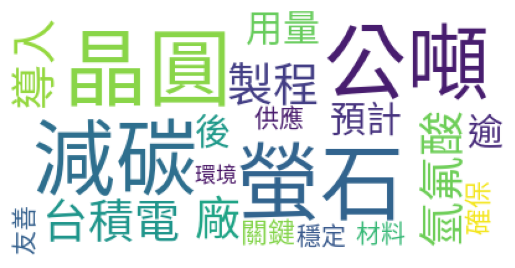

In [12]:
plt.imshow(df_keyword["pic"].iloc[10])
plt.axis("off")
plt.show()


In [35]:
# 將過濾後的單詞轉換為轉換為list of list形式
seg_lst = list(df["N_or_V"])

# corpora.Dictionary() input 是文字的list of list 
dictionary = corpora.Dictionary(seg_lst)
corpus = [dictionary.doc2bow(i) for i in seg_lst]

In [36]:
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes = 30, random_state = 42)
    print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

@jit(target_backend='cuda') 
def perplexity_count(num_topics):
    x = range(1,num_topics+1)
    y = [perplexity(i) for i in x]
    return x, y
    

[(0, '0.019*"台積電" + 0.008*"後" + 0.006*"園區" + 0.006*"環評" + 0.005*"產業" + 0.004*"委員會" + 0.004*"研發" + 0.004*"再生水廠" + 0.004*"技術" + 0.004*"公司" + 0.004*"開發" + 0.004*"進行" + 0.004*"次" + 0.004*"每" + 0.004*"年"')]
-6.786489608485776
[(0, '0.023*"台積電" + 0.008*"公司" + 0.007*"美國" + 0.006*"元" + 0.006*"封裝" + 0.006*"先進" + 0.006*"製程" + 0.006*"晶圓" + 0.005*"技術" + 0.005*"副總裁" + 0.005*"擔任" + 0.005*"三星" + 0.005*"業者" + 0.005*"後" + 0.004*"相關"'), (1, '0.016*"台積電" + 0.011*"園區" + 0.010*"後" + 0.009*"環評" + 0.009*"產業" + 0.007*"再生水廠" + 0.006*"審查" + 0.006*"中油" + 0.006*"楠梓" + 0.005*"每" + 0.005*"開發" + 0.005*"會議" + 0.005*"噸" + 0.005*"進行" + 0.005*"研發"')]
-6.734257541265155
[(0, '0.028*"台積電" + 0.013*"公司" + 0.010*"美國" + 0.010*"封裝" + 0.008*"元" + 0.008*"三星" + 0.008*"副總裁" + 0.008*"擔任" + 0.007*"先進" + 0.007*"委員會" + 0.007*"英特爾" + 0.007*"技術" + 0.005*"累計" + 0.005*"相關" + 0.005*"1"'), (1, '0.021*"台積電" + 0.013*"園區" + 0.009*"環評" + 0.009*"後" + 0.008*"中油" + 0.006*"每" + 0.006*"再生水廠" + 0.006*"會議" + 0.006*"股" + 0.005*"市府" + 0.005*"年" + 0.005*

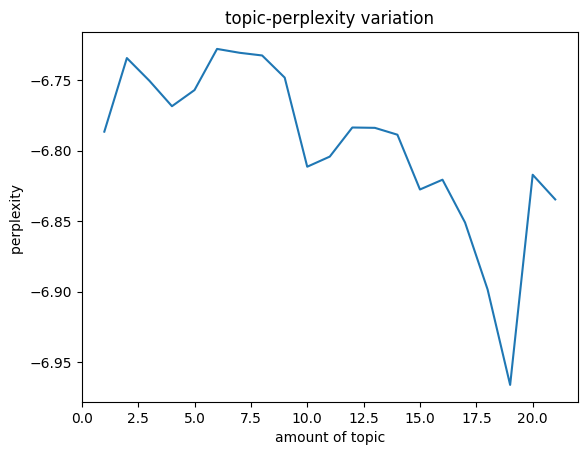

In [37]:
x, y = perplexity_count(21)

plt.plot(x,y)
plt.xlabel("amount of topic")
plt.ylabel("perplexity ")
plt.title("topic-perplexity variation")
plt.show()

In [38]:
# 主題一致性計算
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
    print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
    ldacm = CoherenceModel(model = ldamodel, texts = seg_lst, dictionary = dictionary, coherence="c_v")
    print(ldacm.get_coherence())
    return ldacm.get_coherence()

@jit(target_backend='cuda') 
def coherence_count(num_topics):
    x = range(1,num_topics+1)
    y = [coherence(i) for i in x]
    return x, y
    

[(0, '0.019*"台積電" + 0.008*"後" + 0.006*"園區" + 0.006*"環評" + 0.005*"產業" + 0.004*"委員會" + 0.004*"研發" + 0.004*"再生水廠" + 0.004*"技術" + 0.004*"公司" + 0.004*"開發" + 0.004*"進行" + 0.004*"次" + 0.004*"每" + 0.004*"年"')]
0.35388674165750744
[(0, '0.023*"台積電" + 0.008*"公司" + 0.007*"美國" + 0.006*"元" + 0.006*"封裝" + 0.006*"先進" + 0.006*"製程" + 0.006*"晶圓" + 0.005*"技術" + 0.005*"副總裁" + 0.005*"擔任" + 0.005*"三星" + 0.005*"業者" + 0.005*"後" + 0.004*"相關"'), (1, '0.016*"台積電" + 0.011*"園區" + 0.010*"後" + 0.009*"環評" + 0.009*"產業" + 0.007*"再生水廠" + 0.006*"審查" + 0.006*"中油" + 0.006*"楠梓" + 0.005*"每" + 0.005*"開發" + 0.005*"會議" + 0.005*"噸" + 0.005*"進行" + 0.005*"研發"')]
0.379547756833851
[(0, '0.028*"台積電" + 0.013*"公司" + 0.010*"美國" + 0.010*"封裝" + 0.008*"元" + 0.008*"三星" + 0.008*"副總裁" + 0.008*"擔任" + 0.007*"先進" + 0.007*"委員會" + 0.007*"英特爾" + 0.007*"技術" + 0.005*"累計" + 0.005*"相關" + 0.005*"1"'), (1, '0.021*"台積電" + 0.013*"園區" + 0.009*"環評" + 0.009*"後" + 0.008*"中油" + 0.006*"每" + 0.006*"再生水廠" + 0.006*"會議" + 0.006*"股" + 0.005*"市府" + 0.005*"年" + 0.005*

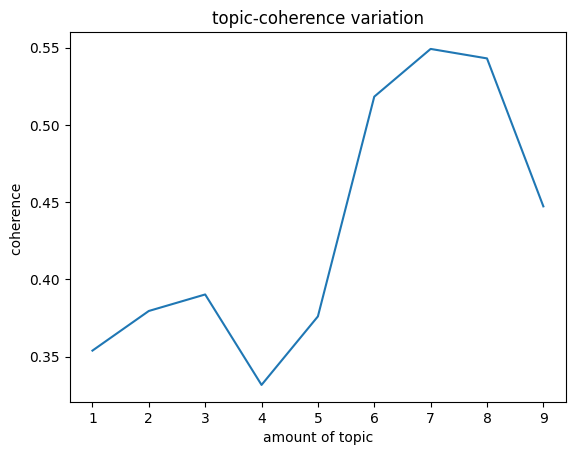

In [39]:
x, y = coherence_count(9)

plt.plot(x,y)
plt.xlabel("amount of topic")
plt.ylabel("coherence ")
plt.title("topic-coherence variation")
plt.show()

In [40]:
num_topics = 7
lda = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
topics_lst = lda.print_topics()
print(topics_lst)

[(0, '0.036*"股" + 0.030*"設質" + 0.024*"股數" + 0.024*"餘額" + 0.012*"200,000" + 0.012*"累計" + 0.012*"中國" + 0.012*"副董事長" + 0.012*"本人" + 0.012*"0"'), (1, '0.021*"台積電" + 0.013*"年" + 0.013*"綠電" + 0.013*"能源" + 0.013*"聯盟" + 0.013*"中科" + 0.013*"再生" + 0.009*"前" + 0.009*"行動" + 0.009*"每"'), (2, '0.017*"產業" + 0.015*"後" + 0.013*"研發" + 0.011*"業者" + 0.011*"審查" + 0.011*"適用" + 0.009*"日本" + 0.009*"政府" + 0.009*"環評" + 0.009*"技術"'), (3, '0.028*"園區" + 0.019*"環評" + 0.014*"台積電" + 0.014*"會議" + 0.009*"承諾" + 0.009*"小組" + 0.009*"規劃" + 0.009*"科學" + 0.009*"產業" + 0.007*"開發"'), (4, '0.040*"台積電" + 0.017*"中油" + 0.013*"公司" + 0.008*"下" + 0.008*"擔任" + 0.008*"薛男" + 0.008*"法院" + 0.008*"離職" + 0.008*"整治" + 0.008*"英特爾"'), (5, '0.024*"再生水廠" + 0.021*"台積電" + 0.016*"噸" + 0.013*"後" + 0.013*"每" + 0.013*"再生水" + 0.013*"工業" + 0.013*"興建" + 0.013*"日" + 0.013*"南科"'), (6, '0.022*"台積電" + 0.015*"美國" + 0.015*"封裝" + 0.013*"三星" + 0.010*"先進" + 0.010*"技術" + 0.010*"委員會" + 0.008*"晶圓" + 0.008*"減碳" + 0.008*"螢石"')]


# **視覺化**

In [47]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
data

# pyLDAvis.save_html(data, f"./{num_topics}_topic_model.html")

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.139387  0.049522       1        1  21.779121
3     -0.118883 -0.038742       2        1  18.891010
4      0.125734  0.024411       3        1  17.278408
6      0.055715  0.143436       4        1  16.423479
5      0.061638 -0.138111       5        1  15.521999
1      0.005852 -0.036494       6        1   7.092848
0      0.009330 -0.004022       7        1   3.013135, topic_info=     Term       Freq      Total Category  logprob  loglift
381  再生水廠   6.000000   6.000000  Default  30.0000  30.0000
212    園區  11.000000  11.000000  Default  29.0000  29.0000
615     股   2.000000   2.000000  Default  28.0000  28.0000
10    台積電  32.000000  32.000000  Default  27.0000  27.0000
618    設質   2.000000   2.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
638    國際   0.041596   4.161259   Topic7  -7.0933  -1.1034
642    投訴   0.041596   2.669023   Topic7  -7.0933  -0.6593
654    美國   0.041594   5.440724   Topic7  -7.0934  -1.3715
651  積體電路   0.041594   2.669026   Topic7  -7.0934  -0.6593
473    公司   0.041593   6.912944   Topic7  -7.0934  -1.6110

[345 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
606       7  0.834924     0
661       6  0.904834  0/17
45        3  0.246277     1
45        4  0.246277     1
45        5  0.246277     1
...     ...       ...   ...
133       5  0.291680    高雄
275       1  0.240857   高雄市
275       2  0.481714   高雄市
275       5  0.240857   高雄市
623       7  0.834924   魏哲家

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 7, 6, 2, 1])